# Case1 (Case1_sub.csv)
> Public Score
> - Case1_sub: 25746.14746

In [193]:
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# column 보기 30개로 설정
pd.set_option('display.max_columns', 30)

In [194]:
# 데이터 경로 설정
file_path = os.path.join(os.getcwd(), 'data')
train_origin = pd.read_csv(file_path+'\dataset.csv')
test_origin = pd.read_csv(file_path+'\problem.csv')

In [195]:
train_origin.shape, test_origin.shape

((1340, 24), (130, 23))

In [196]:
# 전처리를 위한 원본 데이터 복사
train = train_origin.copy()
test = test_origin.copy()

In [197]:
# 메모리를 효율적으로 사용하기 위한 downcast 함수 정의
def downcast(df, verbose=True):     # verbose 옵션 추가: (True)인 경우 몇 퍼센트 압축됐는지 출력
    start_mem = df.memory_usage().sum() / 1024**2   # 초기 메모리 사용량
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'{(100*(start_mem - end_mem) / start_mem):.1f}% 압축됨')

    return df

In [198]:
downcast(train)
downcast(test)

67.2% 압축됨
68.7% 압축됨


,Id,LotArea,Street,LotConfig,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageCars,GarageArea,YrSold
0,1341,11200,Pave,Inside,5,5,1965,1965,1040,1040,0,1040,1,0,3,1,5,0,Detchd,1965,1,384,2008
1,1342,7200,Pave,Corner,5,7,1951,2000,900,900,0,900,1,0,3,1,5,0,Detchd,2005,2,576,2010
2,1343,16905,Pave,Inside,5,6,1959,1959,1350,1328,0,1328,1,1,2,1,5,2,Attchd,1959,1,308,2007
3,1344,9180,Pave,CulDSac,5,7,1983,1983,840,884,0,884,1,0,2,1,5,0,Attchd,1983,2,504,2007
4,1345,7200,Pave,Inside,5,7,1920,1996,530,581,530,1111,1,0,3,1,6,0,Detchd,1935,1,288,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,1466,11478,Pave,Inside,8,5,2007,2008,1704,1704,0,1704,2,0,3,1,7,1,Attchd,2008,3,772,2010
126,1467,16321,Pave,CulDSac,5,6,1957,1997,1484,1600,0,1600,1,0,2,1,6,2,Attchd,1957,1,319,2006
127,1468,6324,Pave,Inside,4,6,1927,1950,520,520,0,520,1,0,1,1,4,0,Detchd,1920,1,240,2008
128,1469,8500,Pave,Inside,4,4,1920,1950,649,649,668,1317,1,0,3,1,6,0,Detchd,1920,1,250,2008


# 전처리

### 결측치 처리

In [199]:
# 최빈값 대체
train['GarageType'].fillna(train['GarageType'].mode()[0], inplace=True)
train['GarageYrBlt'].fillna(train['GarageYrBlt'].mode()[0], inplace=True)

In [200]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

### Feature engineering

In [201]:
# 2010년을 기준으로 건물이 지어진 후 지난 시간(연)
train['YearBuiltDiff'] = 2010 - train['YearBuilt']
test['YearBuiltDiff'] = 2010 - test['YearBuilt']

In [202]:
# 리모델링 후 지난 시간(연)
train['RemodAddDiff'] = 2010 - train['YearRemodAdd']
test['RemodAddDiff'] = 2010 - test['YearRemodAdd']

In [203]:
# 욕실 수 합치기
train['TotalBath'] = train['FullBath'] + train['HalfBath']
test['TotalBath'] = test['FullBath'] + test['HalfBath']

In [204]:
# 총 면적
train['TotalSF'] = train['GrLivArea'] + train['TotalBsmtSF']
test['TotalSF'] = test['GrLivArea'] + test['TotalBsmtSF']

In [205]:
# 2층 여부
train['Has2ndFlr'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['Has2ndFlr'] = test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

In [206]:
# 지하실 여부
train['HasBsmt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasBsmt'] = test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

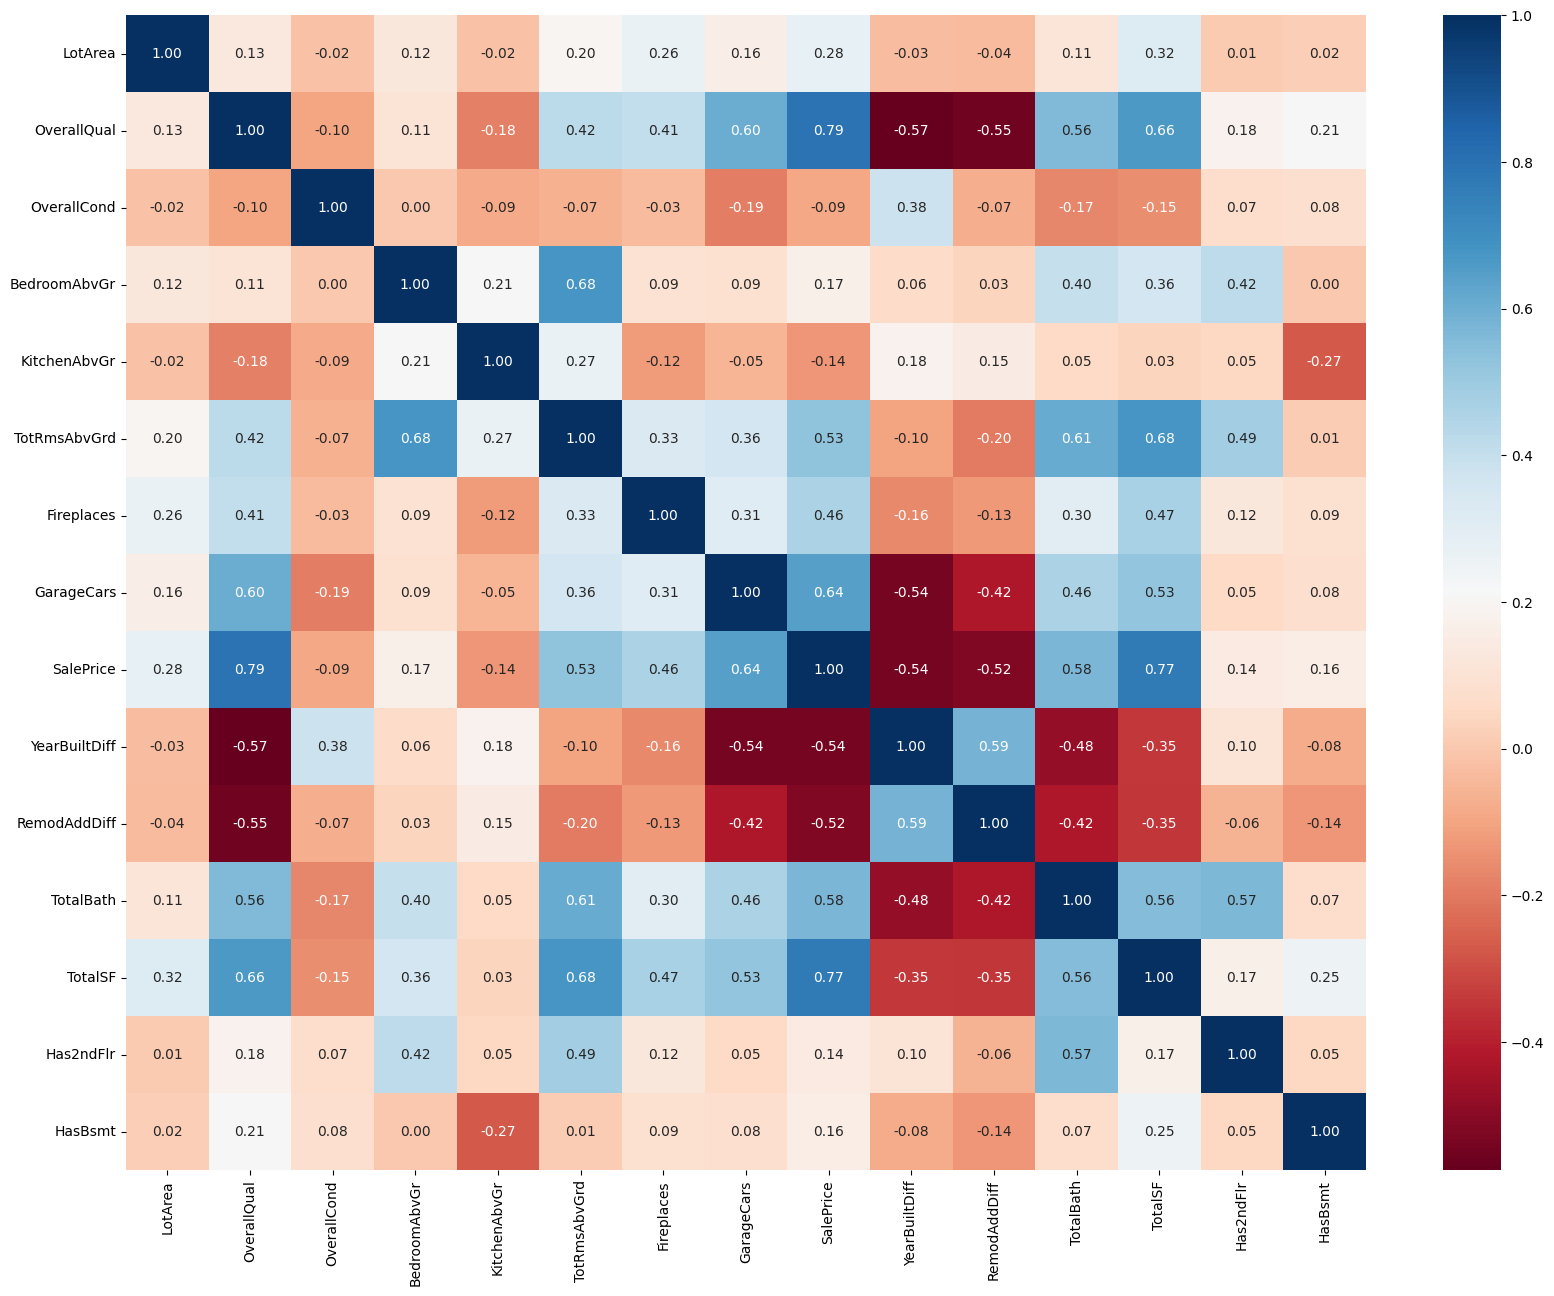

In [212]:
# 상관계수 히트맵
numeric_data = train.select_dtypes(exclude="object")   # 수치형 데이터만 추출
plt.figure(figsize=(20, 15))
#mask = np.zeros_like(numeric_data.corr(), dtype=np.bool_)
#mask[np.triu_indices_from(mask)] = True     # triu_indices_from: 대각선을 기준으로 위쪽 삼각형만 True로 설정
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='RdBu')    # cmap: 색상  # 절반만 표시하고 싶은 경우 mask=mask 옵션 추가
plt.show()

### 일부 feature 제거

In [211]:
train.columns

Index(['LotArea', 'Street', 'LotConfig', 'OverallQual', 'OverallCond',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageType', 'GarageCars', 'SalePrice', 'YearBuiltDiff',
       'RemodAddDiff', 'TotalBath', 'TotalSF', 'Has2ndFlr', 'HasBsmt'],
      dtype='object')

In [209]:
no_use_features = ['Id', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'GarageArea', 'TotalBsmtSF', 'GrLivArea', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath']

In [210]:
train.drop(no_use_features, axis=1, inplace=True)
test.drop(no_use_features, axis=1, inplace=True)

### 중복 데이터 제거

In [172]:
train.duplicated().sum()    # 중복 데이터 확인

2

In [173]:
train = train.drop_duplicates()     # 중복 데이터 제거

### 이상치 처리
> target 값인 SalePrice와 그와 상관관계가 매우 높은 몇 가지 feature만 이상치 처리를 좀 해주자.

> GrLivArea

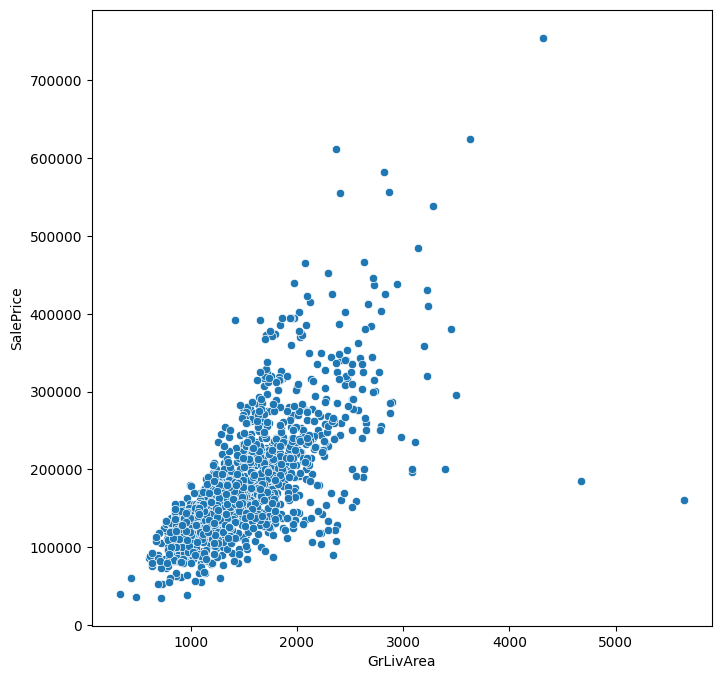

In [174]:
# GrLivArea와 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')
plt.show()

In [175]:
# 이상치 제거
outlier_index = train[(train['SalePrice']<220000)&(train['GrLivArea']>4000)]
train = train.drop(outlier_index.index).reset_index(drop=True)

> TotalBsmtSF

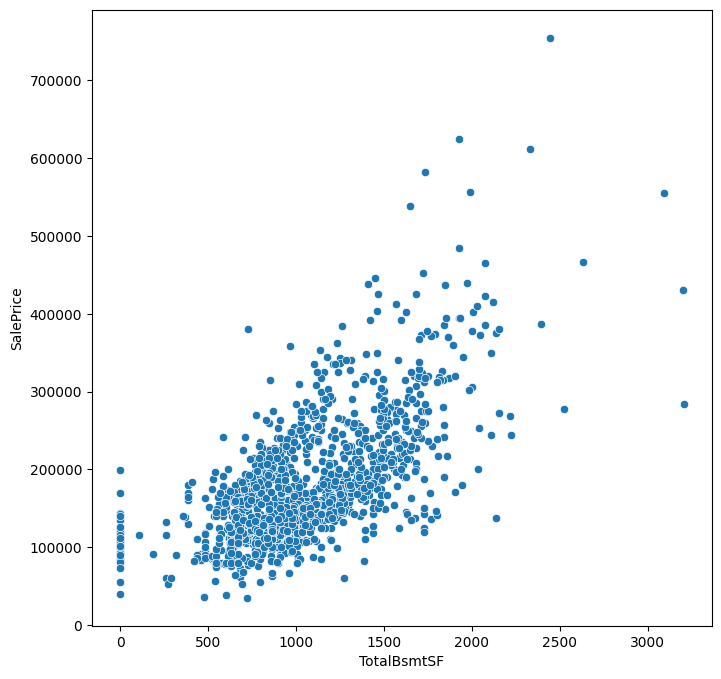

In [176]:
# OverallQual과 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice')
plt.show()

> LotArea 이상치 제거

<Axes: ylabel='LotArea'>

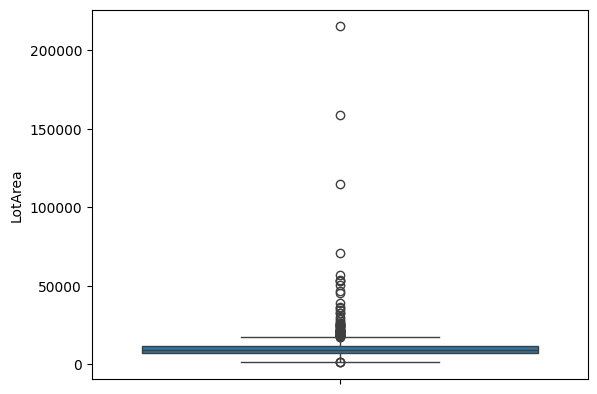

In [177]:
sns.boxplot(train['LotArea'])

In [178]:
# LotArea 이상치 제거
train = train[train['LotArea'] < 100000].reset_index(drop=True)

### Encoding

In [179]:
# X, y 분리
X_train = train.drop(columns='SalePrice', axis=1)
y_train = train['SalePrice']

In [180]:
all_data = pd.concat([X_train, test], axis=0).reset_index(drop=True)

In [181]:
all_data

,LotArea,Street,LotConfig,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageCars,YearBuiltDiff,RemodAddDiff,TotalBath,TotalSF,Has2ndFlr,HasBsmt
0,8450,Pave,Inside,7,5,856,856,854,1710,2,1,3,1,8,0,Attchd,2,7,7,3,2566,1,1
1,9600,Pave,FR2,6,8,1262,1262,0,1262,2,0,3,1,6,1,Attchd,2,34,34,2,2524,0,1
2,11250,Pave,Inside,7,5,920,920,866,1786,2,1,3,1,6,1,Attchd,2,9,8,3,2706,1,1
3,9550,Pave,Corner,7,5,756,961,756,1717,1,0,3,1,7,1,Detchd,3,95,40,1,2473,1,1
4,14260,Pave,FR2,8,5,1145,1145,1053,2198,2,1,4,1,9,1,Attchd,3,10,10,3,3343,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,11478,Pave,Inside,8,5,1704,1704,0,1704,2,0,3,1,7,1,Attchd,3,3,2,2,3408,0,1
1459,16321,Pave,CulDSac,5,6,1484,1600,0,1600,1,0,2,1,6,2,Attchd,1,53,13,1,3084,0,1
1460,6324,Pave,Inside,4,6,520,520,0,520,1,0,1,1,4,0,Detchd,1,83,60,1,1040,0,1
1461,8500,Pave,Inside,4,4,649,649,668,1317,1,0,3,1,6,0,Detchd,1,90,60,1,1966,1,1


In [183]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

categorical = all_data.select_dtypes(include='object').columns

for feature in categorical:
    all_data[feature] = encoder.fit_transform(all_data[feature])

In [184]:
all_data

,LotArea,Street,LotConfig,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,YearBuiltDiff,RemodAddDiff,TotalBath,TotalSF,Has2ndFlr,HasBsmt,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,8450,1,4,7,5,856,856,854,1710,2,1,3,1,8,0,2,7,7,3,2566,1,1,False,True,False,False,False,False
1,9600,1,2,6,8,1262,1262,0,1262,2,0,3,1,6,1,2,34,34,2,2524,0,1,False,True,False,False,False,False
2,11250,1,4,7,5,920,920,866,1786,2,1,3,1,6,1,2,9,8,3,2706,1,1,False,True,False,False,False,False
3,9550,1,0,7,5,756,961,756,1717,1,0,3,1,7,1,3,95,40,1,2473,1,1,False,False,False,False,False,True
4,14260,1,2,8,5,1145,1145,1053,2198,2,1,4,1,9,1,3,10,10,3,3343,1,1,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,11478,1,4,8,5,1704,1704,0,1704,2,0,3,1,7,1,3,3,2,2,3408,0,1,False,True,False,False,False,False
1459,16321,1,1,5,6,1484,1600,0,1600,1,0,2,1,6,2,1,53,13,1,3084,0,1,False,True,False,False,False,False
1460,6324,1,4,4,6,520,520,0,520,1,0,1,1,4,0,1,83,60,1,1040,0,1,False,False,False,False,False,True
1461,8500,1,4,4,4,649,649,668,1317,1,0,3,1,6,0,1,90,60,1,1966,1,1,False,False,False,False,False,True


In [185]:
# 공통 전처리 끝
X_train = all_data.iloc[:len(X_train)]
test = all_data.iloc[len(X_train):].reset_index(drop=True)

In [186]:
X_train.shape, test.shape

((1333, 28), (130, 28))

In [187]:
X_train.loc[:, 'LotArea'] = np.log1p(X_train['LotArea'])
test.loc[:, 'LotArea'] = np.log1p(test['LotArea'])

X_train.loc[:, 'GrLivArea'] = np.log1p(X_train['GrLivArea'])
test.loc[:, 'GrLivArea'] = np.log1p(test['GrLivArea'])

In [145]:
# # 수치형 변수들 Robust Scaling
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler().fit(X_train)

# X_train = scaler.transform(X_train)
# test = scaler.transform(test)

In [188]:
X_train

,LotArea,Street,LotConfig,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,YearBuiltDiff,RemodAddDiff,TotalBath,TotalSF,Has2ndFlr,HasBsmt,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,9.042040,1,4,7,5,856,856,854,7.444833,2,1,3,1,8,0,2,7,7,3,2566,1,1,False,True,False,False,False,False
1,9.169623,1,2,6,8,1262,1262,0,7.141245,2,0,3,1,6,1,2,34,34,2,2524,0,1,False,True,False,False,False,False
2,9.328212,1,4,7,5,920,920,866,7.488294,2,1,3,1,6,1,2,9,8,3,2706,1,1,False,True,False,False,False,False
3,9.164401,1,0,7,5,756,961,756,7.448916,1,0,3,1,7,1,3,95,40,1,2473,1,1,False,False,False,False,False,True
4,9.565284,1,2,8,5,1145,1145,1053,7.695758,2,1,4,1,9,1,3,10,10,3,3343,1,1,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328,8.976894,1,4,6,5,953,953,694,7.407318,2,1,3,1,7,1,2,11,10,3,2600,1,1,False,True,False,False,False,False
1329,9.486152,1,4,6,6,1542,2073,0,7.637234,2,0,3,1,7,2,2,32,22,2,3615,0,1,False,True,False,False,False,False
1330,9.109746,1,4,7,9,1152,1188,1152,7.758334,2,0,4,1,9,2,1,69,4,2,3492,1,1,False,True,False,False,False,False
1331,9.181735,1,4,5,6,1078,1078,0,6.983790,1,0,2,1,5,0,1,60,14,1,2156,0,1,False,True,False,False,False,False


In [189]:
test

,LotArea,Street,LotConfig,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,YearBuiltDiff,RemodAddDiff,TotalBath,TotalSF,Has2ndFlr,HasBsmt,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,9.323758,1,4,5,5,1040,1040,0,6.947937,1,0,3,1,5,0,1,45,45,1,2080,0,1,False,False,False,False,False,True
1,8.881975,1,0,5,7,900,900,0,6.803505,1,0,3,1,5,0,2,59,10,1,1800,0,1,False,False,False,False,False,True
2,9.735424,1,4,5,6,1350,1328,0,7.192182,1,1,2,1,5,2,1,51,51,2,2678,0,1,False,True,False,False,False,False
3,9.124891,1,1,5,7,840,884,0,6.785588,1,0,2,1,5,0,2,27,27,1,1724,0,1,False,True,False,False,False,False
4,8.881975,1,4,5,7,530,581,530,7.013916,1,0,3,1,6,0,1,90,14,1,1641,1,1,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,9.348275,1,4,8,5,1704,1704,0,7.441320,2,0,3,1,7,1,3,3,2,2,3408,0,1,False,True,False,False,False,False
126,9.700269,1,1,5,6,1484,1600,0,7.378384,1,0,2,1,6,2,1,53,13,1,3084,0,1,False,True,False,False,False,False
127,8.752265,1,4,4,6,520,520,0,6.255750,1,0,1,1,4,0,1,83,60,1,1040,0,1,False,False,False,False,False,True
128,9.047939,1,4,4,4,649,649,668,7.183871,1,0,3,1,6,0,1,90,60,1,1966,1,1,False,False,False,False,False,True


# Model training

### XGBoost

In [190]:
# 베이지안 최적화
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10))
    return rmse, rmse.mean()

param_bounds = {
    'learning_rate' : (0.001, 0.5),
    'max_leaves': (2, 1024),
    'n_estimators': (100, 1000),
    'gamma': (0, 10),
    'max_depth': (3, 15),
    'min_child_weight': (1, 20),
    }

def eval_function(max_leaves, learning_rate, n_estimators, gamma, max_depth, min_child_weight):
    params = {
        'learning_rate' : learning_rate, 
        'max_leaves': int(max_leaves),
        'n_estimators': int(n_estimators),
        'gamma': gamma,
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
    }

    xgb_model = XGBRegressor(**params, random_state=42)
    score, mean_score = rmse_cv(xgb_model)
    return -mean_score

In [191]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(f=eval_function, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   |   gamma   | learni... | max_depth | max_le... | min_ch... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -2.9e+04  | 3.745     | 0.4754    | 11.78     | 613.8     | 3.964     | 240.4     |
| 2         | -2.827e+0 | 0.5808    | 0.4332    | 10.21     | 725.7     | 1.391     | 972.9     |
| 3         | -2.558e+0 | 8.324     | 0.107     | 5.182     | 189.4     | 6.781     | 572.3     |
| 4         | -2.662e+0 | 4.319     | 0.1463    | 10.34     | 144.6     | 6.551     | 429.7     |
| 5         | -2.742e+0 | 4.561     | 0.3928    | 5.396     | 527.5     | 12.26     | 141.8     |
| 6         | -2.855e+0 | 1.683     | 0.4184    | 9.587     | 195.4     | 14.69     | 560.0     |
| 7         | -2.741e+0 | 1.242     | 0.3566    | 11.89     | 161.9     | 13.04     | 896.4     |
| 8         | -2.837e+0 | 2.104     | 0.4963    | 5.567     | 718.5     | 10.42     | 358.9     |
| 9         | -2.726

In [192]:
# 최적화된 하이퍼파라미터로 모델 재학습
best_params = {
    'n_estimators': round(optimizer.max['params']['n_estimators']),
    'max_depth': round(optimizer.max['params']['max_depth']),
    'max_leaves': round(optimizer.max['params']['max_leaves']),
    'min_child_weight': round(optimizer.max['params']['min_child_weight']),
    'learning_rate': optimizer.max['params']['learning_rate'],
    'gamma': optimizer.max['params']['gamma'],
}

best_xgb = XGBRegressor(**best_params, random_state=42)
score, mean_score = rmse_cv(best_xgb)
print(score)
print(mean_score)

[22905.03242352 22444.87506822 24978.37213448 28862.27321647
 34956.6574697  25161.59017601 25545.79694678 20865.27441011
 24462.9228501  24438.56262115]
25462.135731654453


In [37]:
# 모델의 결정계수 확인
from sklearn.metrics import r2_score

best_xgb = XGBRegressor(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_train)

r2_score(y_pred, y_train)

0.9728200358133743

# 결과 제출

In [41]:
# submission 파일 생성
submission_origin = pd.read_csv(file_path+'\submission.csv')
submission = submission_origin.copy()

In [42]:
# 최종 모델(XGBRegressor)로 test set 예측
xgb_pred = best_xgb.predict(test)

submission['SalePrice'] = xgb_pred
submission.to_csv('Case1_sub.csv', index=False)